In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
from scipy import stats

# Census API Key
from config import census_api_key
c = Census(census_api_key, year=2017)

In [2]:
# The following code is a slightly modified version of that found in the bootcamp on sections pertaining to the census module.
# The count for races is grabbed from the census for anyone with at least that race.  A person who is present in multiple
#    categories is counted multiple times.  This counting method was chosen as it focuses primarily on a race being present.
census_data = c.acs5.get(("NAME", "B01003_001E", "B02008_001E", "B02009_001E", "B02010_001E", "B02011_001E",
                         "B02012_001E", "B02013_001E",), {'for': 'county:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering.  Nomenclature is that of the census.
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B02008_001E": "White",
                                      "B02009_001E": "Black or African American",
                                      "B02010_001E": "American Indian and Alaskan Native",
                                      "B02011_001E": "Asian",
                                      "B02012_001E": "Native Hawaiian and Other Pacific Islander",
                                      "B02013_001E": "Other",
                                      "NAME": "Name"})


# Final DataFrame
census_df = census_pd[["Name", "Population", "White", "Black or African American", "American Indian and Alaskan Native",
                       "Asian", "Native Hawaiian and Other Pacific Islander", "Other"]]



# Dataframe is output and saved as csv.
census_df.to_csv("CSV_files/acs5_2017_race.csv")
census_df

,Name,Population,White,Black or African American,American Indian and Alaskan Native,Asian,Native Hawaiian and Other Pacific Islander,Other
0,"Corozal Municipio, Puerto Rico",34933.0,29786.0,3413.0,0.0,0.0,67.0,3087.0
1,"Maunabo Municipio, Puerto Rico",11297.0,3831.0,7142.0,43.0,0.0,0.0,447.0
2,"Peñuelas Municipio, Puerto Rico",21661.0,17199.0,869.0,29.0,63.0,43.0,3690.0
3,"Ponce Municipio, Puerto Rico",148863.0,130902.0,20907.0,494.0,189.0,12.0,10503.0
4,"San Sebastián Municipio, Puerto Rico",38970.0,28642.0,1544.0,0.0,97.0,21.0,9287.0
...,...,...,...,...,...,...,...,...
3215,"Iowa County, Wisconsin",23576.0,22999.0,235.0,117.0,212.0,29.0,213.0
3216,"Pepin County, Wisconsin",7282.0,7189.0,50.0,42.0,37.0,1.0,23.0
3217,"Ozaukee County, Wisconsin",87817.0,83985.0,1660.0,480.0,2518.0,124.0,575.0
3218,"Portage County, Wisconsin",70371.0,66815.0,955.0,603.0,2357.0,78.0,775.0


In [3]:
# Broadband dataframe is pulled from csv, then limited to only values in 2017.
broadband_df = pd.read_csv("CSV_files/clean_broadband.csv")
broadband_2017_data = broadband_df.loc[broadband_df["Year"] == 2017]
broadband_2017_data.head()

# Empty array for String to be merged on is initialized 
name = []

# for loop crafts the correct string to be merged by each row.
for index, row in broadband_2017_data.iterrows():
    name.append(f'{row["County"]}, {row["State"]}')

# Dataframe to be merged, such that only 2 columns are created, is crafted    
broadband_2017_df = pd.DataFrame({"Name": name,
                                 "Broadband (%)":broadband_2017_data["Broadband (%)"],
                                 "GEO ID": broadband_2017_data["GEO ID"]})
broadband_2017_df.head()

,Name,Broadband (%),GEO ID
0,"Autauga County, Alabama",0.618182,0500000US01001
12,"Baldwin County, Alabama",0.820682,0500000US01003
14,"Barbour County, Alabama",0.478992,0500000US01005
16,"Bibb County, Alabama",0.606742,0500000US01007
18,"Blount County, Alabama",0.586694,0500000US01009


In [4]:
# Census data and broadband data are merged into one dataframe
census_2017_acs5_race_df = pd.merge(census_df, broadband_2017_df, how='inner', on="Name")

# Merged dataframe is saved as a csv and output
census_2017_acs5_race_df.to_csv("CSV_files/census_2017_acs5_race_df.csv")
census_2017_acs5_race_df.head()

,Name,Population,White,Black or African American,American Indian and Alaskan Native,Asian,Native Hawaiian and Other Pacific Islander,Other,Broadband (%),GEO ID
0,"Monroe County, Alabama",21745.0,12326.0,9262.0,546.0,116.0,0.0,0.0,0.538071,0500000US01099
1,"Lawrence County, Alabama",33288.0,27729.0,4006.0,3030.0,111.0,0.0,184.0,0.666667,0500000US01079
2,"Lee County, Alabama",156597.0,111991.0,37502.0,1212.0,6639.0,71.0,2190.0,0.829926,0500000US01081
3,"Marion County, Alabama",30058.0,28518.0,1271.0,291.0,259.0,118.0,249.0,0.553030,0500000US01093
4,"Pickens County, Alabama",20170.0,11534.0,8425.0,76.0,44.0,10.0,403.0,0.572917,0500000US01107


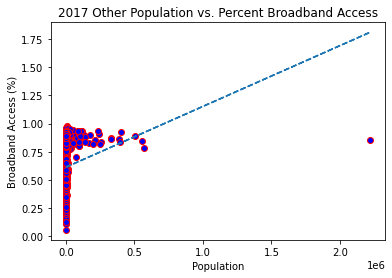

In [5]:
# This section runs a linear regression for population of all races and broadband access

# Array of column headers to be analyzed against broadband access as a percent
headers = ["White", "Black or African American", "American Indian and Alaskan Native",
                       "Asian", "Native Hawaiian and Other Pacific Islander", "Other"]

# Arrays to hold r and r-squared values are initilaized
r_squared = []
r_values = []

# for loop looping through each header
for header in headers:

    # Clears figure so plots do not superimpose
    plt.clf()
    
    # Lists for x and y values are defined
    x = census_2017_acs5_race_df[header]
    y = census_2017_acs5_race_df['Broadband (%)']

    # Linear regression is run
    header_slope, header_int, header_r, p, std_err = stats.linregress(x ,y)
    header_fit = header_slope * x + header_int

    # Plot is crafted and labeled then linear regression and r-squared is superimposed
    plt.scatter(x ,y , marker="o", facecolors="blue", edgecolors="red")
    plt.title(f'2017 {header} Population vs. Percent Broadband Access')
    plt.xlabel(f'Population')
    plt.ylabel("Broadband Access (%)")
    plt.plot(x , header_fit,"--")
    
    # r_squared values are added to a list
    r_squared.append(f'The r-squared for {header} population is {round(header_r**2,3)}.')
    r_values.append(f'The r-value for {header} population is {round(header_r,3)}.')

    # plot is output and saved as a png
    plt.savefig(f'output_charts/2017_acs5_{header}_lin_regress.png',format='png')

In [6]:
r_squared

['The r-squared for White population is 0.189.',
 'The r-squared for Black or African American population is 0.088.',
 'The r-squared for American Indian and Alaskan Native population is 0.075.',
 'The r-squared for Asian population is 0.05.',
 'The r-squared for Native Hawaiian and Other Pacific Islander population is 0.016.',
 'The r-squared for Other population is 0.026.']

In [7]:
r_values

['The r-value for White population is 0.435.',
 'The r-value for Black or African American population is 0.297.',
 'The r-value for American Indian and Alaskan Native population is 0.274.',
 'The r-value for Asian population is 0.224.',
 'The r-value for Native Hawaiian and Other Pacific Islander population is 0.127.',
 'The r-value for Other population is 0.16.']